# Set up

In [21]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

In [9]:
element_gameweek_df['is_high_points'] = \
element_gameweek_df['total_points'].apply(lambda x: 1 if x >= 10 else 0)

# Modelling data

## Splitting data

In [10]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [11]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [12]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points', 'is_high_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [13]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [50]:
formula = \
'is_high_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     'is_high_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
     
 ]])

In [51]:
print(formula)

is_high_points ~ C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element

In [52]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [53]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Principal components

In [17]:
X.design_info.column_name_indexes

OrderedDict([('Intercept', 0),
             ('C(element)[T.2]', 1),
             ('C(element)[T.4]', 2),
             ('C(element)[T.5]', 3),
             ('C(element)[T.6]', 4),
             ('C(element)[T.7]', 5),
             ('C(element)[T.8]', 6),
             ('C(element)[T.9]', 7),
             ('C(element)[T.11]', 8),
             ('C(element)[T.12]', 9),
             ('C(element)[T.13]', 10),
             ('C(element)[T.14]', 11),
             ('C(element)[T.15]', 12),
             ('C(element)[T.17]', 13),
             ('C(element)[T.18]', 14),
             ('C(element)[T.22]', 15),
             ('C(element)[T.23]', 16),
             ('C(element)[T.24]', 17),
             ('C(element)[T.26]', 18),
             ('C(element)[T.27]', 19),
             ('C(element)[T.28]', 20),
             ('C(element)[T.29]', 21),
             ('C(element)[T.31]', 22),
             ('C(element)[T.33]', 23),
             ('C(element)[T.35]', 24),
             ('C(element)[T.36]', 25),
          

In [18]:
pca = PCA()
pca.fit(X_train[:,401:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

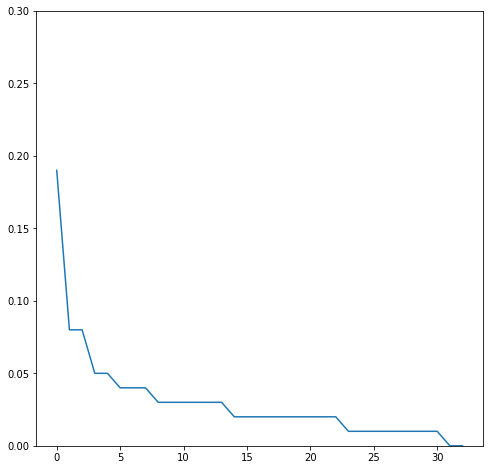

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(pca.explained_variance_ratio_.round(2))
plt.ylim(0, 0.3)
plt.show()

In [20]:
X_train_pca = np.concatenate((X_train[:,:401], pca.transform(X_train[:,401:])), axis=1)
X_train_pca.shape

(2696, 434)

In [21]:
X_test_pca = np.concatenate((X_test[:,:401], pca.transform(X_test[:,401:])), axis=1)
X_test_pca.shape

(948, 434)

In [22]:
X_pca = np.concatenate((X[:,:401], pca.transform(X[:,401:])), axis=1)
X_pca.shape

(3644, 434)

## Selecting features

### Linear regression

In [123]:
X_lr = np.concatenate((np.ones((len(X_pca), 1)), X_pca[:,354:]), axis=1)
X_train_lr = np.concatenate((np.ones((len(X_train_pca), 1)), X_train_pca[:,354:]), axis=1)
X_test_lr = np.concatenate((np.ones((len(X_test_pca), 1)), X_test_pca[:,354:]), axis=1)

In [124]:
lr_estimator = LinearRegression()
lr_selector = RFECV(lr_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lr_selector.fit(X_lr, y.ravel())

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [125]:
sum(lr_selector.support_)

71

In [126]:
lr_X_sel = X_lr[:,lr_selector.support_]
lr_X_train_sel = X_train_lr[:,lr_selector.support_]
lr_X_test_sel = X_test_lr[:,lr_selector.support_]

### Ridge regression

In [29]:
ridge_estimator = Ridge(alpha=500)
ridge_selector = RFECV(ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
ridge_selector.fit(X_pca, y.ravel())

Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
F

Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
F

Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
F

Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=500, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [30]:
sum(ridge_selector.support_)

28

In [31]:
ridge_X_sel = X_pca[:,ridge_selector.support_]
ridge_X_train_sel = X_train_pca[:,ridge_selector.support_]
ridge_X_test_sel = X_test_pca[:,ridge_selector.support_]

### Lasso regression

In [65]:
lasso_estimator = Lasso(alpha=0.024)
lasso_selector = RFECV(lasso_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lasso_selector.fit(X_pca, y.ravel())

Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
F

Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
F

Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
F

Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.024, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [66]:
sum(lasso_selector.support_)

30

In [67]:
lasso_X_sel = X_pca[:,lasso_selector.support_]
lasso_X_train_sel = X_train_pca[:,lasso_selector.support_]
lasso_X_test_sel = X_test_pca[:,lasso_selector.support_]

## Tuning model

### GP tuner

#### Ridge regression

In [42]:
ridge_space  = [Real(10**0, 10**3, 'log-uniform', name='alpha')]

In [43]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
            X,
#             X_pca,
#             ridge_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [44]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(ridge_objective, ridge_space, n_calls=100, verbose=2)
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0844
Function value obtained: 9.4077
Current minimum: 9.4077
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0779
Function value obtained: 9.8057
Current minimum: 9.4077
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0782
Function value obtained: 10.2756
Current minimum: 9.4077
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0836
Function value obtained: 9.3704
Current minimum: 9.3704
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1080
Function value obtained: 9.7998
Current minimum: 9.3704
Iteration

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.7266
Function value obtained: 9.3717
Current minimum: 9.3661
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8191
Function value obtained: 9.3686
Current minimum: 9.3661
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.1101
Function value obtained: 9.3661
Current minimum: 9.3661
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.7698
Function value obtained: 9.3661
Current minimum: 9.3661
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.7923
Function value obtained: 9.3688
Current minimum: 9.3661
Iteration No: 46 started. Sea

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.2650
Function value obtained: 9.3840
Current minimum: 9.3661
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.2783
Function value obtained: 9.3661
Current minimum: 9.3661
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.2091
Function value obtained: 9.3699
Current minimum: 9.3661
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.3338
Function value obtained: 9.3746
Current minimum: 9.3661
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.3681
Function value obtained: 9.3661
Current minimum: 9.3661
Iteration No: 86 started. Sea

In [28]:
# Full PCA (with elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.366112187371959


[500.1396529454353]


In [35]:
# Selected PCA (with elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.208785430734245


[27.548752912230427]


In [45]:
# Full features (with elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.366112237809032


[499.76666439284014]


#### Lasso regression

In [61]:
lasso_space  = [Real(10**-4, 10**1, 'log-uniform', name='alpha')]

In [71]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
            X,
#             X_pca,
#             lasso_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [72]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(lasso_objective, lasso_space, n_calls=100, verbose=2)
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4924
Function value obtained: 10.8728
Current minimum: 10.8728
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5034
Function value obtained: 10.1051
Current minimum: 10.1051
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0725
Function value obtained: 10.0907
Current minimum: 10.0907
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0898
Function value obtained: 9.4235
Current minimum: 9.4235
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.4077
Function value obtained: 10.8713
Current minimum: 9.4235
Ite

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 896.0260845171397, tolerance: 2.5000491097922866
  positive)


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.5291
Function value obtained: 12.0351
Current minimum: 9.2916
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8258
Function value obtained: 9.2915
Current minimum: 9.2915
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7905
Function value obtained: 9.2915
Current minimum: 9.2915
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7704
Function value obtained: 9.2915
Current minimum: 9.2915
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.8134
Function value obtained: 9.2915
Current minimum: 9.2915
Iteration No: 31 started. Se

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.0855
Function value obtained: 9.2913
Current minimum: 9.2913
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.0522
Function value obtained: 9.2913
Current minimum: 9.2913
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.1157
Function value obtained: 9.2914
Current minimum: 9.2913
Iteration No: 69 started. Searching for the next optimal point.
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.1125
Function value obtained: 9.2913
Current minimum: 9.2913
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.1977
Function value obtained: 9.2920
Current minimum: 9.2913
Iteration No: 71 started. Sea

In [64]:
# Full PCA (with elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.310116404496641


[0.024727098415556738]


In [70]:
# Selected PCA (with elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.111446722147017


[0.0001]


In [73]:
# Full features (with elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.291208953317883


[0.027098069523122235]


# Evaluating model

## Logistic regression

In [57]:
model = LogisticRegression(
    penalty='none',
    class_weight='balanced',
    solver='newton-cg'
)
model.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [58]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred)
)
test_loss

(0.1145374449339207, 0.5777777777777777)

In [59]:
confusion_matrix(y_test, y_pred)

array([[702, 201],
       [ 19,  26]])

In [60]:
pd.DataFrame(list(zip(X.design_info.column_names, model.coef_.round(1)[0])), columns=['feature', 'weight']).sort_values('weight')
# model.coef_.round(1)[0]

,feature,weight
34,C(opposition_team)[T.13],-14.9
19,C(team)[T.17],-2.0
33,C(opposition_team)[T.12],-1.8
11,C(team)[T.9],-1.5
0,Intercept,-1.1
18,C(team)[T.16],-1.1
17,C(team)[T.15],-1.0
8,C(team)[T.6],-1.0
16,C(team)[T.14],-0.8
15,C(team)[T.13],-0.7


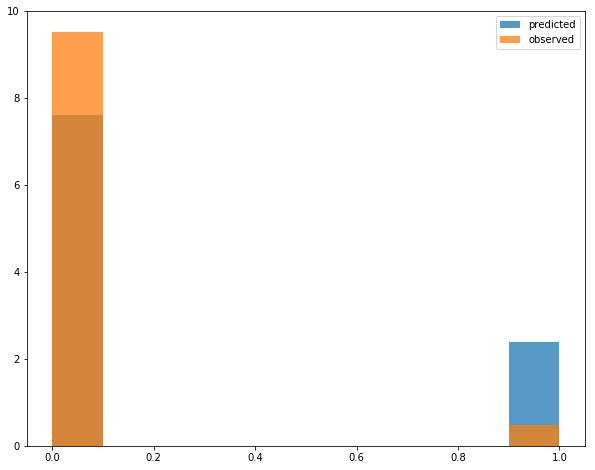

In [68]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

## Summary

In [67]:
pd.DataFrame([
    ('Logistic regression', test_loss[0], test_loss[1]),
], columns=['model', 'precision', 'recall'])

,model,precision,recall
0,Logistic regression,0.114537,0.577778
